In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import statsmodels.formula.api as smf

from LC_functions import print_def, success_rates, lift_chart, cost_plot, recall_plot

pd.options.display.max_columns = 2000
pd.options.display.max_rows = 200

In [2]:
# Either pass in a list of columns to use via logit_cols_ 
# or pass in a list of columns to drop via logit_drop_
def smf_logit(df_, y_, logit_cols_=None, logit_drop_=None):
    """
    PARAMETERS
    ----------
    df_: pandas DataFrame() containing all data.
    y_: string name of target column
    logit_cols_: list of columns to use
    logit_drop_: ist of columns to drop from df_, remaining are used.
    
    WHAT IT DOES
    ------------
    Prints a typical econometric-package-style model summary.
    """
    
    if logit_drop_:
        sm_df = df_.drop(labels=logit_drop_, axis=1).dropna()
    elif logit_cols_:
        sm_df = df_.loc[:, logit_cols_+[y_]].copy().dropna()   
    else:
        sm_df = df_.copy().dropna()
        
    formula = y_ + " ~ "
    for column in sm_df.drop(labels=[y_], axis=1).columns:
        formula += column + " + "
    formula = formula[:-3]
    
    print("Formula") 
    print("-------", "\n", f"{formula}\n")
    sm_model = smf.logit(formula, data=sm_df).fit()
    print(sm_model.summary())

In [3]:
# read in datasets
df_train = pd.read_csv("lending_club_sample_preprocessed_train.csv")
df_test = pd.read_csv("lending_club_sample_preprocessed_test.csv")
df_validate = pd.read_csv("lending_club_sample_preprocessed_validate.csv")
df_biased = pd.read_csv("lending_club_biased_preprocessed.csv")

In [4]:
for item in df_train.columns.sort_values():
    print_def(item)

acc_now_delinq - The number of accounts on which the borrower is now delinquent.
acc_open_past_24mths - Number of trades opened in past 24 months.
***addr_state_AK: New feature, not in original dictionary.
***addr_state_AL: New feature, not in original dictionary.
***addr_state_AR: New feature, not in original dictionary.
***addr_state_AZ: New feature, not in original dictionary.
***addr_state_CA: New feature, not in original dictionary.
***addr_state_CO: New feature, not in original dictionary.
***addr_state_CT: New feature, not in original dictionary.
***addr_state_DC: New feature, not in original dictionary.
***addr_state_DE: New feature, not in original dictionary.
***addr_state_FL: New feature, not in original dictionary.
***addr_state_GA: New feature, not in original dictionary.
***addr_state_HI: New feature, not in original dictionary.
***addr_state_ID: New feature, not in original dictionary.
***addr_state_IL: New feature, not in original dictionary.
***addr_state_IN: New featu

In [5]:
# Drop duplicate target column and object-type date columns
XG_drop_cols = ["loan_status"]+list(df_train.select_dtypes(include='object').columns)

df_train = df_train.drop(labels=XG_drop_cols, axis=1)
df_test = df_test.drop(labels=XG_drop_cols, axis=1)
df_validate = df_validate.drop(labels=XG_drop_cols, axis=1)
df_biased = df_biased.drop(labels=XG_drop_cols, axis=1)

In [6]:
df_train.head()

,funded_amnt,installment,annual_inc,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_amnt,last_fico_range_high,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_il_tl,num_op_rev_tl,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,term_36months,initial_list_status_w,individual,hardhship,employed_over_10yrs,emp_years,interest_rate,revolving_util,issue_date_year,years_since_earliest_cr_line,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,issue_date_month_1,issue_date_month_10,issue_date_month_11,issue_date_month_12,issue_date_month_2,issue_date_month_3,issue_date_month_4,issue_date_month_5,issue_date_month_6,issue_date_month_7,issue_date_month_8,issue_date_month_9,target
0,21000.0,474.49,94000.0,19.33,1.0,669.0,0.0,16.0,2.0,5124.0,50.0,24772.33,24772.33,21000.00,3772.33,0.0,0.00,16634.22,759.0,0.0,0.0,0.0,161930.0,9600.0,3.0,11566.0,2664.0,60.8,0.0,0.0,140.0,242.0,23.0,10.0,3.0,32.0,4.0,0.0,5.0,7.0,24.0,10.0,7.0,16.0,0.0,0.0,0.0,2.0,95.1,60.0,2.0,0.0,129078.0,161930.0,6800.0,119478.0,1,1,1,0,0,0.0,12.69,53.4,2015,20.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,0
1,18500.0,495.82,30000.0,31.32,0.0,754.0,0

In [7]:
# A list of 1 category from each object set as well as DateTime features for ease of dropping.
logit_drop_cols = ["grade_G", "sub_grade_G5", "home_ownership_NONE", 
                   "purpose_other", "addr_state_WY", "issue_date_month_12"] + \
                    list(df_train.select_dtypes(include='datetime').columns)

# df.drop(labels=logit_drop_cols, axis=1, inplace=True)

In [8]:
# Run a simple logistic regression using statsmodels
use_cols = ["last_fico_range_high", "last_pymnt_amnt", "total_rec_prncp", 
            "funded_amnt", "issue_date_year", "installment", 
            "total_pymnt_inv", "total_pymnt"]

smf_logit(df_train, "target", logit_cols_=use_cols)

Formula
------- 
 target ~ last_fico_range_high + last_pymnt_amnt + total_rec_prncp + funded_amnt + issue_date_year + installment + total_pymnt_inv + total_pymnt

Optimization terminated successfully.
         Current function value: 0.109789
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49991
Method:                           MLE   Df Model:                            8
Date:                Thu, 10 Aug 2023   Pseudo R-squ.:                  0.7084
Time:                        21:54:43   Log-Likelihood:                -5489.5
converged:                       True   LL-Null:                       -18825.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
-------------

Confusion Matrix: 
[[4300   79]
 [ 164  457]]
Accuracy: 0.9514


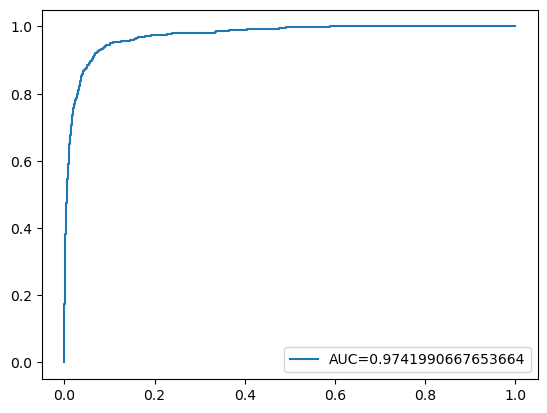

Max Accuracy cutoff: 0.45


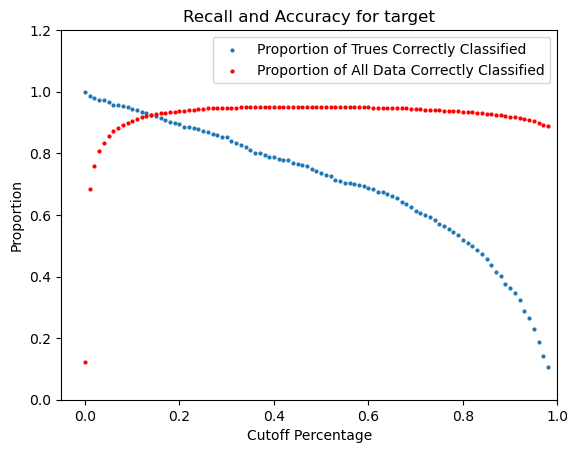

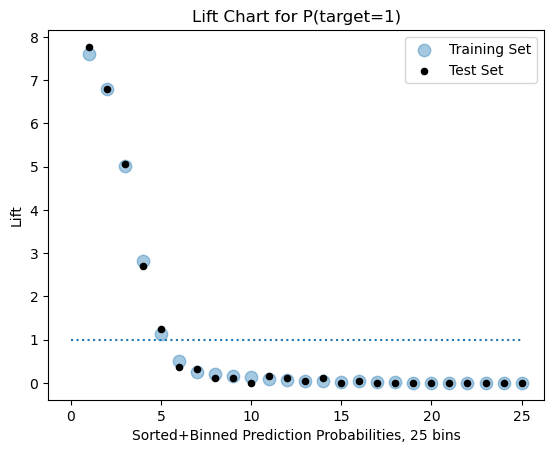

Max Accuracy cutoff: 0.45
Min cost cutoff: 0.11


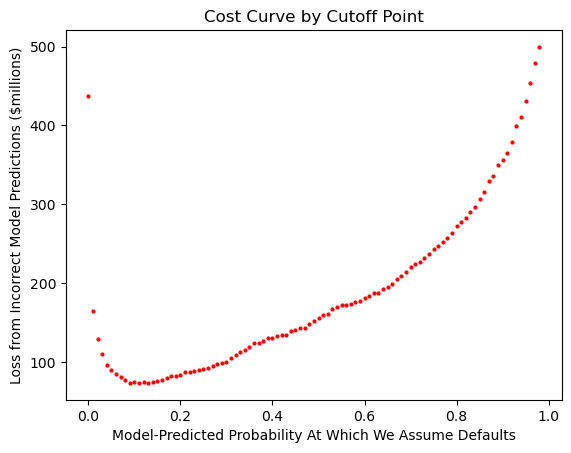

In [17]:
# Split target vectors from feature matrices
X_train = df_train.loc[:, use_cols]
y_train = df_train.target

X_test = df_test.loc[:, use_cols]
y_test = df_test.target

#instantiate the model
model = LogisticRegression(max_iter=250)

#fit the model using the training data
model.fit(X_train,y_train)

#use model to make predictions on test data
y_pred = model.predict(X_test)
# confusion matrix [True 0, False 1], [False 0, True 1]
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix: \n{cnf_matrix}")
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred)}")

#define metrics
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

# Lift Chart

recall_plot(model, X_test, y_test)
lift_chart(model, X_train, X_test, y_train, y_test, bins=25)
cost_plot(model, X_test, y_test)

In [15]:
def copy_pasta(df_):
    copy_string = ""
    for col in df_.columns:
        copy_string += f"\"{col}\", "
    return copy_string[:-2]


In [16]:
print(copy_pasta(df_train))

"funded_amnt", "installment", "annual_inc", "dti", "delinq_2yrs", "fico_range_high", "inq_last_6mths", "open_acc", "pub_rec", "revol_bal", "total_acc", "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries", "last_pymnt_amnt", "last_fico_range_high", "collections_12_mths_ex_med", "acc_now_delinq", "tot_coll_amt", "tot_cur_bal", "total_rev_hi_lim", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy", "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct", "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc", "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl", "num_actv_rev_tl", "num_il_tl", "num_op_rev_tl", "num_rev_tl_bal_gt_0", "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m", "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies", "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",